Imports


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns

import glob as gb
import tensorflow as tf
import matplotlib.image as mpimg
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from  matplotlib import pyplot as plt
from keras import models 
from keras import layers
from scipy import fftpack

from skimage import io, color
from skimage.color import rgb2gray
from skimage.io import imread
from PIL import Image as im
from PIL import ImageFile

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
def create_data_frame_for_folder_mean_red_and_green_rgb_images(filepath,label):
  list_of_green_mean_intensities=[]
  list_of_red_mean_intensities=[]
  df = pd.DataFrame()
  files = gb.glob(pathname= str(filepath+'/*.png'))
  for file in files:
      image = cv2.imread(file)
      b,g,r = cv2.split(image)
      
      list_of_green_mean_intensities.append(np.mean(g))
      list_of_red_mean_intensities.append(np.mean(r))
  labels_list=[label]*len(list_of_green_mean_intensities)
  df['Mean intensity of green']=list_of_green_mean_intensities
  df['Mean intensity of red']=list_of_red_mean_intensities

  df['Aniematic']=labels_list
  return df



Helper functions

In [ ]:
#CieLAB images functions

#Check if pixel is white
def IsWhite(pixel):
  white=255
  white_counter=0
  is_white=False
  for i in range(0,3):
    if(pixel[i]==white):
      white_counter=white_counter+1
  if(white_counter==3):
    is_white=True
  return(is_white)
#to reach cielab you must go from rgb to xyz
#these conversions are from a website
def convert_from_rgb_to_xyz(pixel):
  var_R = ( pixel[0] / 255 )
  var_G = ( pixel[1] / 255 )
  var_B = ( pixel[2] / 255 )

  if ( var_R > 0.04045 ):
    var_R = ( ( var_R + 0.055 ) / 1.055 ) ** 2.4
  else:
    var_R = var_R / 12.92
  if ( var_G > 0.04045 ):
    var_G = ( ( var_G + 0.055 ) / 1.055 ) ** 2.4
  else:
    var_G = var_G / 12.92
  if ( var_B > 0.04045 ):
    var_B = ( ( var_B + 0.055 ) / 1.055 )** 2.4
  else:
    var_B = var_B / 12.92

  var_R = var_R * 100
  var_G = var_G * 100
  var_B = var_B * 100

  X = var_R * 0.4124 + var_G * 0.3576 + var_B * 0.1805
  Y = var_R * 0.2126 + var_G * 0.7152 + var_B * 0.0722
  Z = var_R * 0.0193 + var_G * 0.1192 + var_B * 0.9505
  return [X,Y,Z]

def convert_from_xyz_to_lab(xyz_pixel):
  #these constants are from skimage documentation 
  X=95.047
  Y=100.000
  Z=108.883
  var_X = xyz_pixel[0] / X
  var_Y = xyz_pixel[1] / Y
  var_Z = xyz_pixel[2] / Z

  if ( var_X > 0.008856 ):
     var_X = var_X** ( 1/3 )
  else:
     var_X = ( 7.787 * var_X ) + ( 16 / 116 )
  if ( var_Y > 0.008856 ):
     var_Y = var_Y ** ( 1/3 )
  else:
     var_Y = ( 7.787 * var_Y ) + ( 16 / 116 )
  if ( var_Z > 0.008856 ):
     var_Z = var_Z ** ( 1/3 )
  else :
     var_Z = ( 7.787 * var_Z ) + ( 16 / 116 )

  l = ( 116 * var_Y ) - 16
  a = 500 * ( var_X - var_Y )
  b = 200 * ( var_Y - var_Z )
  return l,a,b


In [ ]:
def create_data_frame_with_mean_of_red_and_green(folder_path,label):#cielab
  list_of_red_components=[]
  list_of_green_components=[]
  list_of_means_of_green=[]
  list_of_means_of_red=[]
  df = pd.DataFrame()
  #read image
  #edit to fit png 
  files = gb.glob(pathname= str(folder_path+'/*.png'))
  for file in files:
    image = io.imread(file)
    image_height=image.shape[0]
    image_width=image.shape[1]
    list_of_new_image_pixels=[]
    #choose non white pixels in the image
    for h in range(0,image_height):
      for w in range(0,image_width):
        if(IsWhite(image[h][w])==False):
          list_of_new_image_pixels.append(image[h][w])

    list_of_a_values=[]
    
    for i in range (0,len(list_of_new_image_pixels)):
      converted_to_xyz_pixel=convert_from_rgb_to_xyz(list_of_new_image_pixels[i])
      l,a,b=convert_from_xyz_to_lab(converted_to_xyz_pixel)
      list_of_a_values.append(a)
    #caluclate red and green components for a list 
    for i in range (0,len(list_of_a_values)):
        if(list_of_a_values[i]>0):
          list_of_red_components.append(list_of_a_values[i])
        elif(list_of_a_values[i]<0):
          list_of_green_components.append(list_of_a_values[i])
    list_of_means_of_green.append(np.mean(list_of_green_components))
    list_of_means_of_red.append(np.mean(list_of_red_components))
    

  labels_list=[label]*len(list_of_means_of_green)
  df['Mean intensity of green']=list_of_means_of_green
  df['Mean intensity of red']=pd.Series(list_of_means_of_red)

  df['Aniematic']=labels_list
  return df

In [ ]:
def create_data_frame_with_mean_of_red_and_green_no_background_rgb(folder_path,label):
  list_of_red_components=[]
  list_of_green_components=[]
  list_of_means_of_green=[]
  list_of_means_of_red=[]
  df = pd.DataFrame()
  #read image
  #edit to fit png 
  files = gb.glob(pathname= str(folder_path+'/*.jpg'))
  for file in files:
    image = io.imread(file)
    image_height=image.shape[0]
    image_width=image.shape[1]
    list_of_new_image_pixels=[]
    #print(folder_path)

    #choose non white pixels in the image
    for h in range(0,image_height):
      for w in range(0,image_width):
        if(IsWhite(image[h][w])==False):
          list_of_new_image_pixels.append(image[h][w])

    #convert pixel list from rgb to cielab
    list_of_red_components = [x for [x, y, z] in list_of_new_image_pixels]
    list_of_green_components = [y for [x, y, z] in list_of_new_image_pixels]
    #print(list_of_red_components)
    list_of_means_of_green.append(np.mean(list_of_green_components))
    list_of_means_of_red.append(np.mean(list_of_red_components))

    #caluclate red and green components for a list 
    
    

  labels_list=[label]*len(list_of_means_of_green)
  df['Mean intensity of green']=list_of_means_of_green
  df['Mean intensity of red']=list_of_means_of_red
  df['Aniematic']=labels_list
  return df

In [ ]:
#testing functions
egypt_dataframe_0=create_data_frame_with_mean_of_red_and_green("/content/drive/MyDrive/Data/segmented/not_aniemia",0)
egypt_dataframe_1=create_data_frame_with_mean_of_red_and_green("/content/drive/MyDrive/Data/segmented/aniemia",1)
egypt_dataframe_cielab=pd.concat([egypt_dataframe_1,egypt_dataframe_0])

KeyboardInterrupt: ignored

In [ ]:

egypt_dataframe_cielab = egypt_dataframe_cielab.dropna()

egypt_dataframe_cielab
egypt_dataframe_cielab.to_csv('/content/drive/MyDrive/Datasets/Aniemia/csv files/cielab/egypt_dataframe_cielab.csv')
egypt_dataframe_cielab


,Mean intensity of green,Mean intensity of red,Aniematic
0,-9.400787,17.910197,1
1,-9.400787,16.200343,1
2,-8.498932,15.259114,1
3,-8.789701,17.575960,1
4,-9.446878,17.138113,1
5,-8.941037,16.790445,1
6,-8.963634,17.794721,1
7,-8.981090,18.242521,1
8,-9.123016,18.254467,1
9,-8.822529,17.977316,1


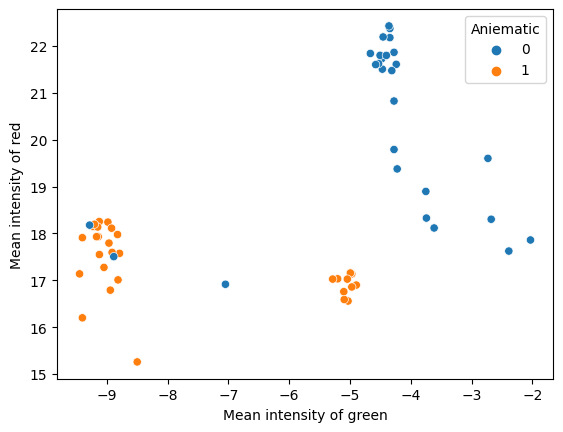

In [ ]:
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=egypt_dataframe_cielab,hue='Aniematic')
plt.show()

In [ ]:
#function to extract median of channels to add it as a feature
def extract_median(folder_path,label):
  files = gb.glob(pathname= str(folder_path+'/*.jpg'))
  list_of_g_medians=[]
  list_of_r_medians=[]
  df = pd.DataFrame()

  for file in files:
        image = cv2.imread(file)
        b, g, r = cv2.split(image) # Split channels
        # Remove zeros
        g = g[g != 0]
        r = r[r != 0]
        g=g[g != 255]
        r=r[r != 255]
        # median values
        r_median = np.median(r)
        g_median = np.median(g)
        list_of_g_medians.append(g_median)
        list_of_r_medians.append(r_median)
  df['Median of green']=list_of_g_medians
  df['Median of red']=list_of_r_medians

  return df




In [ ]:
df1=create_data_frame_with_mean_of_red_and_green_no_background_rgb('/content/drive/MyDrive/Datasets/Aniemia/Used in ML dataset/dataset anemia - Copy/Forniceal Dataset/Aniematic',1)
df0=create_data_frame_with_mean_of_red_and_green_no_background_rgb('/content/drive/MyDrive/Datasets/Aniemia/Used in ML dataset/dataset anemia - Copy/Forniceal Dataset/Non_Aniematic',0)
df_forniceal_rgb_no_background=pd.concat([df1,df0])
df1=create_data_frame_with_mean_of_red_and_green_no_background_rgb('/content/drive/MyDrive/Datasets/Aniemia/Used in ML dataset/dataset anemia - Copy/Palpebral Dataset/Aniematic',1)
df0=create_data_frame_with_mean_of_red_and_green_no_background_rgb('/content/drive/MyDrive/Datasets/Aniemia/Used in ML dataset/dataset anemia - Copy/Palpebral Dataset/Non_Aniematic',0)
df_palpebral_no_background=pd.concat([df1,df0])
df1=create_data_frame_with_mean_of_red_and_green_no_background_rgb('/content/drive/MyDrive/Datasets/Aniemia/Used in ML dataset/dataset anemia - Copy/Forniceal palpebral Dataset/Aniematic',1)
df0=create_data_frame_with_mean_of_red_and_green_no_background_rgb('/content/drive/MyDrive/Datasets/Aniemia/Used in ML dataset/dataset anemia - Copy/Forniceal palpebral Dataset/Non_Aniematic',0)
df_forniceal_palpebral_no_background=pd.concat([df1,df0])
#df1=extract_median('/content/drive/MyDrive/Datasets/Aniemia/Dataset for dataframe/dataset anemia - Copy/Eyes Dataset/Aniematic',1)
#df0=extract_median('/content/drive/MyDrive/Datasets/Aniemia/Dataset for dataframe/dataset anemia - Copy/Eyes Dataset/Non_Aniematic',0)
#df_eyes=pd.concat([df1,df0])

In [ ]:
df_forniceal_rgb_no_background.to_csv('/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_forniceal_rgb_no_background.csv')
df_palpebral_no_background.to_csv('/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_palpebral_rgb_no_background.csv')
df_forniceal_palpebral_no_background.to_csv('/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_forniceal_palpebral_rgb_no_background.csv')

In [ ]:
df_forniceal_rgb_no_background


,Mean intensity of green,Mean intensity of red,Aniematic
0,153.481314,191.956852,1
1,151.830911,191.215423,1
2,137.994514,193.537653,1
3,150.200561,190.270306,1
4,141.861080,199.903201,1
...,...,...,...
109,109.065341,164.788734,0
110,140.762890,179.863462,0
111,120.580782,178.054816,0
112,119.687464,164.461018,0


In [ ]:
data_cielab_fp=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/cielab/df_forniceal_palpebral2.csv")
data_cielab_p=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/cielab/df_palpebral2.csv")
data_cielab_f=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/cielab/df_forniceal2.csv")
data_rgb_fp_no_background=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_forniceal_palpebral_rgb_no_background.csv")
data_rgb_p_no_background=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_palpebral_rgb_no_background.csv")
data_rgb_f_no_background=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_forniceal_rgb_no_background.csv")
data_rgb_fp=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_forniceal_palpebralnew.csv")
data_rgb_p=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/datasetpalpebralnew.csv")
data_rgb_f=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/rgb/df_fornicealnew.csv")
data_egypt_cielab=pd.read_csv(r"/content/drive/MyDrive/Datasets/Aniemia/csv files/cielab/egypt_dataframe_cielab.csv")

In [ ]:
df_cielab_mixed_data_fp=pd.concat([data_cielab_fp,data_egypt_cielab])
df_cielab_mixed_data_f=pd.concat([data_cielab_f,data_egypt_cielab])
df_cielab_mixed_data_p=pd.concat([data_cielab_p,data_egypt_cielab])


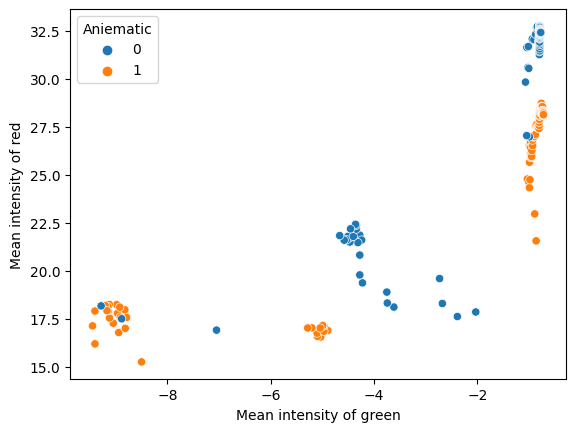

In [ ]:
df_cielab_mixed_data_fp
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=df_cielab_mixed_data_fp,hue='Aniematic')
plt.show()

In [ ]:
features=['Mean intensity of green','Mean intensity of red']


In [ ]:
data_cielab_fp

,Unnamed: 0,Mean intensity of green,Mean intensity of red,Aniematic
0,0,-0.863192,21.565868,1
1,1,-0.889914,22.971307,1
2,2,-0.993238,24.757966,1
3,3,-1.033498,24.787154,1
4,4,-1.002398,24.618989,1
...,...,...,...,...
205,107,-0.775627,32.448125,0
206,108,-0.774660,32.448239,0
207,109,-0.774592,32.437953,0
208,110,-0.774457,32.414778,0


In [ ]:
im1 = cv2.imread("/content/drive/MyDrive/Datasets/Aniemia/Dataset for dataframe/dataset anemia - Copy/Palpebral Dataset/Aniematic/001_palpebral.jpg")
b, g, r = cv2.split(im1) # Split channels
        # Remove zeros
b = b[b != 0]
g = g[g != 0]
r = r[r != 0]
g=g[g != 255]
r=r[r != 255]
b=b[b != 255]
rgb = np.dstack((r,g,b))

plt.imshow(im1)
plt.imshow(rgb)



ValueError: ignored

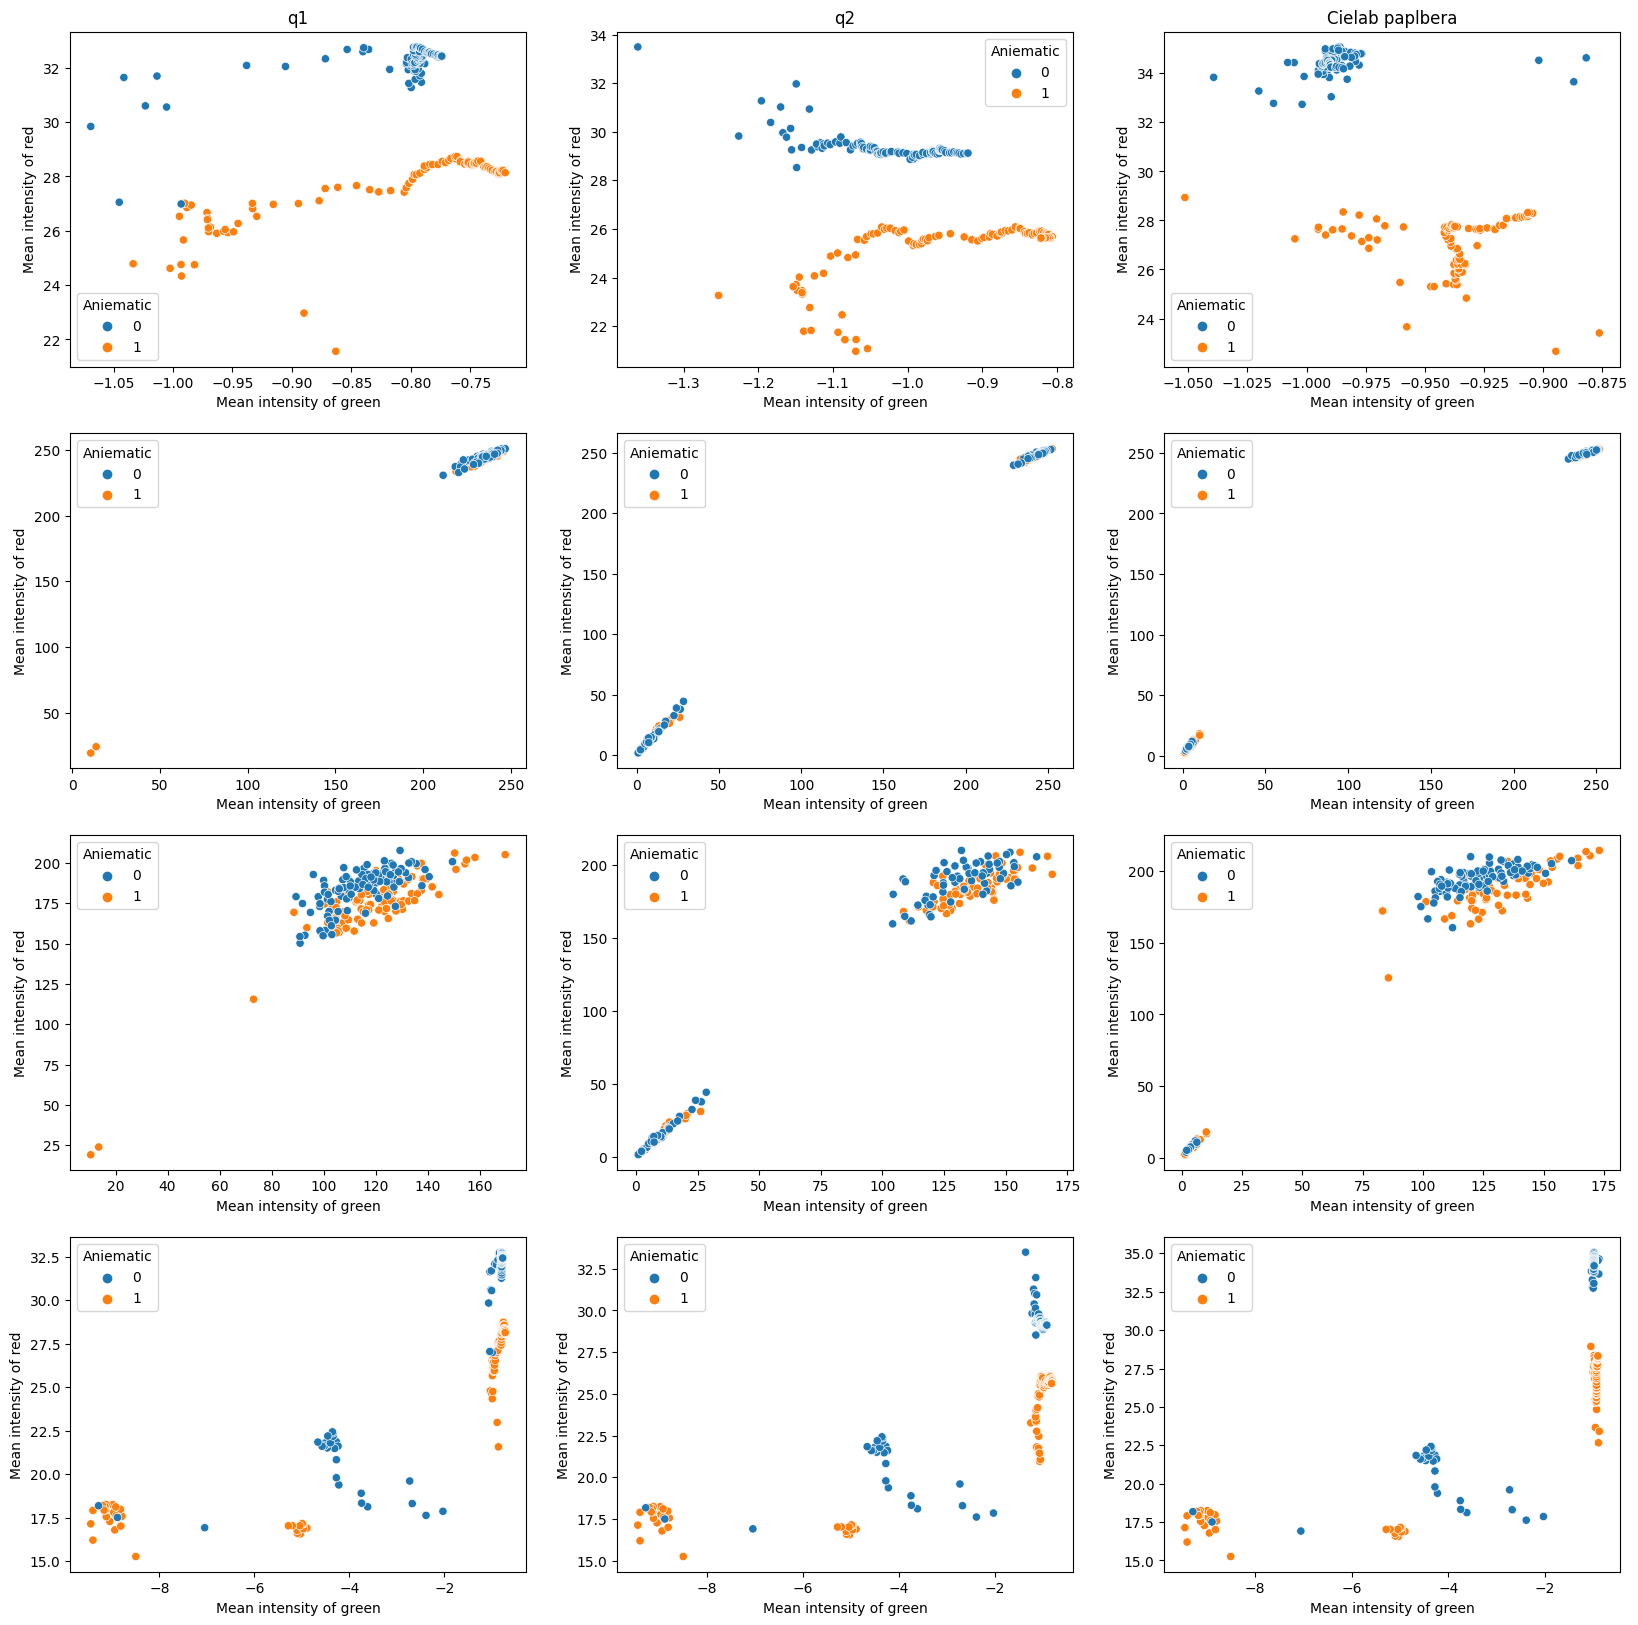

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
 
# reading the database
fig, axs = plt.subplots(4,3,figsize=(20, 20))

axs[0,0].set_title('q1')
axs[0,1].set_title('q2')
axs[0,2].set_title('Cielab paplbera')

sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_cielab_fp,hue='Aniematic',ax=axs[0,0])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_cielab_f,hue='Aniematic',ax=axs[0,1])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_cielab_p,hue='Aniematic',ax=axs[0,2])

sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_rgb_fp,hue='Aniematic',ax=axs[1,0])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_rgb_f,hue='Aniematic',ax=axs[1,1])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_rgb_p,hue='Aniematic',ax=axs[1,2])

sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_rgb_fp_no_background,hue='Aniematic',ax=axs[2,0])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_rgb_f_no_background,hue='Aniematic',ax=axs[2,1])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data_rgb_p_no_background,hue='Aniematic',ax=axs[2,2])

sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=df_cielab_mixed_data_fp,hue='Aniematic',ax=axs[3,0])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=df_cielab_mixed_data_f,hue='Aniematic',ax=axs[3,1])
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=df_cielab_mixed_data_p,hue='Aniematic',ax=axs[3,2])
plt.show()

In [ ]:
sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=egypt_dataframe,hue='Aniematic')
plt.show()

NameError: ignored

Making dataset variables , splitting data to train and test

In [ ]:
x_cielab_fp=data_cielab_fp[features]
y_cielab_fp=data_cielab_fp.iloc[:,-1:]
y_cielab_fp=y_cielab_fp.values.ravel()

x_cielab_f=data_cielab_f[features]
y_cielab_f=data_cielab_f.iloc[:,-1:]
y_cielab_f=y_cielab_f.values.ravel()

x_cielab_p=data_cielab_p[features]
y_cielab_p=data_cielab_p.iloc[:,-1:]
y_cielab_p=y_cielab_p.values.ravel()


x_rgb_fp=data_rgb_fp[features]
y_rgb_fp=data_rgb_fp.iloc[:,-1:]
y_rgb_fp=y_rgb_fp.values.ravel()

x_rgb_f=data_rgb_f[features]
y_rgb_f=data_rgb_f.iloc[:,-1:]
y_rgb_f=y_rgb_f.values.ravel()

x_rgb_p=data_rgb_p[features]
y_rgb_p=data_rgb_p.iloc[:,-1:]
y_rgb_p=y_rgb_p.values.ravel()


x_rgb_fp_nb=data_rgb_fp_no_background[features]
y_rgb_fp_nb=data_rgb_fp_no_background.iloc[:,-1:]
y_rgb_fp_nb=y_rgb_fp_nb.values.ravel()

x_rgb_f_nb=data_rgb_f_no_background[features]
y_rgb_f_nb=data_rgb_f_no_background.iloc[:,-1:]
y_rgb_f_nb=y_rgb_f_nb.values.ravel()

x_rgb_p_nb=data_rgb_p_no_background[features]
y_rgb_p_nb=data_rgb_p_no_background.iloc[:,-1:]
y_rgb_p_nb=y_rgb_p_nb.values.ravel()

#x_cielab_egypt=data_egypt_cielab[features]
#y_cielab_egypt=data_egypt_cielab.iloc[:,-1:]

x_cielab_mixed_fp=df_cielab_mixed_data_fp[features]
y_cielab_mixed_fp=df_cielab_mixed_data_fp["Aniematic"]
#y_cielab_mixed_fp=df_cielab_mixed_data_fp.values.ravel()

x_cielab_mixed_f=df_cielab_mixed_data_f[features]
y_cielab_mixed_f=df_cielab_mixed_data_f["Aniematic"]
#y_cielab_mixed_f=df_cielab_mixed_data_f.values.ravel()

x_cielab_mixed_p=df_cielab_mixed_data_p[features]
y_cielab_mixed_p=df_cielab_mixed_data_p["Aniematic"]
#y_cielab_mixed_p=df_cielab_mixed_data_p.values.ravel()

x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp=train_test_split(x_cielab_fp,y_cielab_fp,test_size=0.3,random_state=0)
x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f=train_test_split(x_cielab_f,y_cielab_f,test_size=0.3,random_state=0)
x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p=train_test_split(x_cielab_p,y_cielab_p,test_size=0.3,random_state=0)

x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp=train_test_split(x_rgb_fp,y_rgb_fp,test_size=0.3,random_state=0)
x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f=train_test_split(x_rgb_f,y_rgb_f,test_size=0.3,random_state=0)
x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p=train_test_split(x_rgb_p,y_rgb_p,test_size=0.3,random_state=0)


x_train_rgb_fp_nb,x_test_rgb_fp_nb,y_train_rgb_fp_nb,y_test_rgb_fp_nb=train_test_split(x_rgb_fp_nb,y_rgb_fp_nb,test_size=0.3,random_state=0)
x_train_rgb_f_nb,x_test_rgb_f_nb,y_train_rgb_f_nb,y_test_rgb_f_nb=train_test_split(x_rgb_f_nb,y_rgb_f_nb,test_size=0.3,random_state=0)
x_train_rgb_p_nb,x_test_rgb_p_nb,y_train_rgb_p_nb,y_test_rgb_p_nb=train_test_split(x_rgb_p_nb,y_rgb_p_nb,test_size=0.3,random_state=0)

#x_train_cielab_egypt,x_test_cielab_egypt,y_train_cielab_egypt,y_test_cielab_egypt=train_test_split(x_cielab_fp,y_cielab_fp,test_size=0.3,random_state=0)


x_train_cielab_fp_m,x_test_cielab_fp_m,y_train_cielab_fp_m,y_test_cielab_fp_m=train_test_split(x_cielab_mixed_fp,y_cielab_mixed_fp,test_size=0.3,random_state=0)
x_train_cielab_f_m,x_test_cielab_f_m,y_train_cielab_f_m,y_test_cielab_f_m=train_test_split(x_cielab_mixed_f,y_cielab_mixed_f,test_size=0.3,random_state=0)
x_train_cielab_p_m,x_test_cielab_p_m,y_train_cielab_p_m,y_test_cielab_p_m=train_test_split(x_cielab_mixed_p,y_cielab_mixed_p,test_size=0.3,random_state=0)


Getting hyper parameters for log reg

In [ ]:
from sklearn.model_selection import GridSearchCV

param_log = {'C': np.logspace(-12, 12, num=22),'penalty' : ['l2']}

log_model=LogisticRegression() 
def logreg_hyper_parameters(x_train,y_train):
  log_gscv = GridSearchCV(log_model, param_log)
  log_gscv.fit(x_train, y_train)
  log_best_parameters=log_gscv.best_params_
  C_log=log_best_parameters['C']
  penalty_log=log_best_parameters['penalty']
  print("C value is : ",C_log,"penalty value is:",penalty_log)
  return(C_log,penalty_log)


C_log_cielab_fp,penalty_log_cielab_fp=logreg_hyper_parameters(x_train_cielab_fp, y_train_cielab_fp)
C_log_cielab_f,penalty_log_cielab_f=logreg_hyper_parameters(x_train_cielab_f, y_train_cielab_f)
C_log_cielab_p,penalty_log_cielab_p=logreg_hyper_parameters(x_train_cielab_p, y_train_cielab_p)

C_log_rgb_fp,penalty_log_rgb_fp=logreg_hyper_parameters(x_train_rgb_fp, y_train_rgb_fp)
C_log_rgb_f,penalty_log_rgb_f=logreg_hyper_parameters(x_train_rgb_f, y_train_rgb_f)
C_log_rgb_p,penalty_log_rgb_p=logreg_hyper_parameters(x_train_rgb_p, y_train_rgb_p)

C_log_rgb_fp_nb,penalty_log_rgb_fp_nb=logreg_hyper_parameters(x_train_rgb_fp_nb, y_train_rgb_fp_nb)
C_log_rgb_f_nb,penalty_log_rgb_f_nb=logreg_hyper_parameters(x_train_rgb_f_nb, y_train_rgb_f_nb)
C_log_rgb_p_nb,penalty_log_rgb_p_nb=logreg_hyper_parameters(x_train_rgb_p_nb, y_train_rgb_p_nb)

#C_log_cielab_egypt,penalty_log_cielab_egypt=logreg_hyper_parameters(x_train_cielab_egypt, y_train_cielab_egypt)


C_log_cielab_fp_m,penalty_log_cielab_fp_m=logreg_hyper_parameters(x_train_cielab_fp_m, y_train_cielab_fp_m)
C_log_cielab_f_m,penalty_log_cielab_f_m=logreg_hyper_parameters(x_train_cielab_f_m, y_train_cielab_f_m)
C_log_cielab_p_m,penalty_log_cielab_p_m=logreg_hyper_parameters(x_train_cielab_p_m, y_train_cielab_p_m)


C value is :  719.6856730011499 penalty value is: l2
C value is :  0.001389495494373136 penalty value is: l2
C value is :  0.001389495494373136 penalty value is: l2
C value is :  0.26826957952797165 penalty value is: l2
C value is :  0.019306977288832457 penalty value is: l2
C value is :  51.79474679231202 penalty value is: l2
C value is :  0.001389495494373136 penalty value is: l2
C value is :  0.019306977288832457 penalty value is: l2
C value is :  0.001389495494373136 penalty value is: l2
C value is :  0.019306977288832457 penalty value is: l2
C value is :  0.019306977288832457 penalty value is: l2
C value is :  0.019306977288832457 penalty value is: l2


Training , testing and scoring of log reg

In [ ]:
def logreg_training_testing_scoring(c,penalty,x_train,x_test,y_train,y_test):
  logreg = LogisticRegression(C=  c,penalty= penalty)
  logreg.fit(x_train,y_train)
  log_train=logreg.score(x_train,y_train)
  log_test=logreg.score(x_test,y_test)
  print("log train score is:",log_train,"log test is",log_test)
  return logreg

logreg_cielab_fp = logreg_training_testing_scoring(C_log_cielab_fp,penalty_log_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
logreg_cielab_f = logreg_training_testing_scoring(C_log_cielab_f,penalty_log_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
logreg_cielab_p = logreg_training_testing_scoring(C_log_cielab_p,penalty_log_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

logreg_rgb_fp = logreg_training_testing_scoring(C_log_rgb_fp,penalty_log_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
logreg_rgb_f = logreg_training_testing_scoring(C_log_rgb_f,penalty_log_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
logreg_rgb_p = logreg_training_testing_scoring(C_log_rgb_p,penalty_log_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

logreg_rgb_fp_nb = logreg_training_testing_scoring(C_log_rgb_fp_nb,penalty_log_rgb_fp_nb,x_train_rgb_fp_nb,x_test_rgb_fp_nb,y_train_rgb_fp_nb,y_test_rgb_fp_nb)
logreg_rgb_f_nb = logreg_training_testing_scoring(C_log_rgb_f_nb,penalty_log_rgb_f_nb,x_train_rgb_f_nb,x_test_rgb_f_nb,y_train_rgb_f_nb,y_test_rgb_f_nb)
logreg_rgb_p_nb = logreg_training_testing_scoring(C_log_rgb_p_nb,penalty_log_rgb_p_nb,x_train_rgb_p_nb,x_test_rgb_p_nb,y_train_rgb_p_nb,y_test_rgb_p_nb)

#logreg_cielab_egypt = logreg_training_testing_scoring(C_log_cielab_egypt,penalty_log_cielab_egypt,x_train_cielab_egypt,x_test_cielab_egypt,y_train_cielab_egypt,y_test_cielab_egypt)


logreg_cielab_fp_m = logreg_training_testing_scoring(C_log_cielab_fp_m,penalty_log_cielab_fp_m,x_train_cielab_fp_m,x_test_cielab_fp_m,y_train_cielab_fp_m,y_test_cielab_fp_m)
logreg_cielab_f_m = logreg_training_testing_scoring(C_log_cielab_f_m,penalty_log_cielab_f_m,x_train_cielab_f_m,x_test_cielab_f_m,y_train_cielab_f_m,y_test_cielab_f_m)
logreg_cielab_p_m = logreg_training_testing_scoring(C_log_cielab_p_m,penalty_log_cielab_p_m,x_train_cielab_p_m,x_test_cielab_p_m,y_train_cielab_p_m,y_test_cielab_p_m)


log train score is: 0.9931972789115646 log test is 1.0
log train score is: 1.0 log test is 1.0
log train score is: 1.0 log test is 1.0
log train score is: 0.7891156462585034 log test is 0.7619047619047619
log train score is: 0.6081081081081081 log test is 0.5625
log train score is: 0.7350993377483444 log test is 0.7384615384615385
log train score is: 0.7619047619047619 log test is 0.746031746031746
log train score is: 0.6283783783783784 log test is 0.671875
log train score is: 0.7814569536423841 log test is 0.7384615384615385
log train score is: 0.893048128342246 log test is 0.8888888888888888
log train score is: 0.8994708994708994 log test is 0.9012345679012346
log train score is: 0.8900523560209425 log test is 0.927710843373494


Plotting decision boundaries

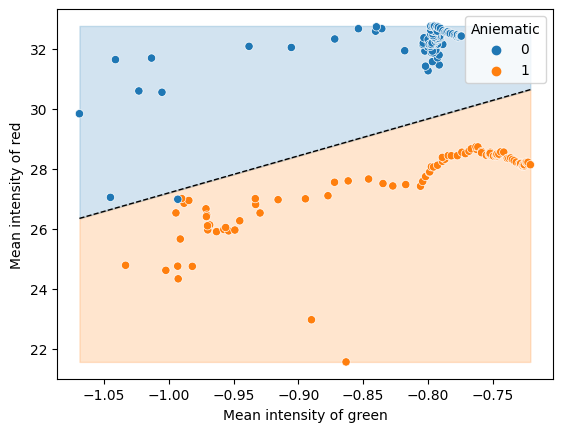

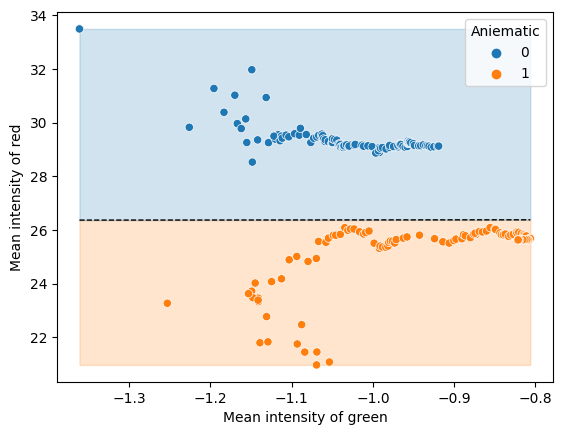

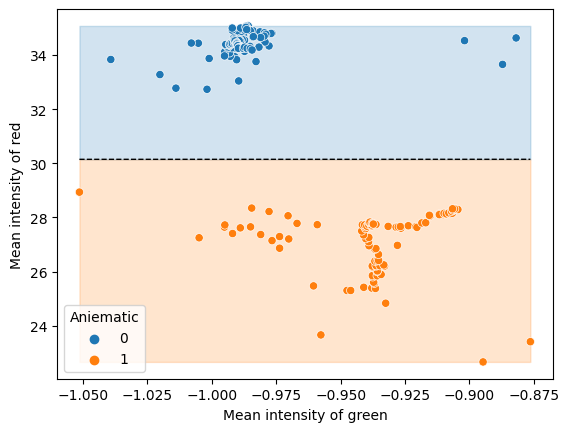

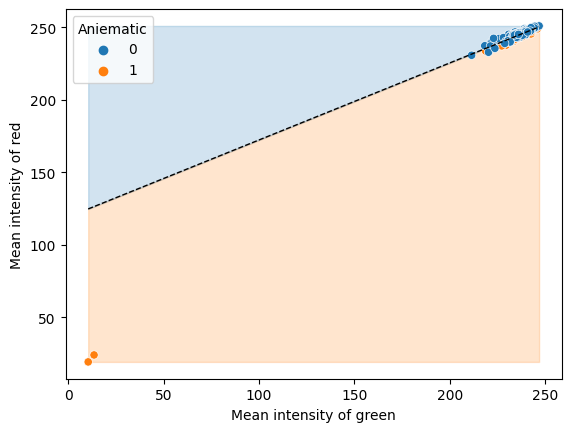

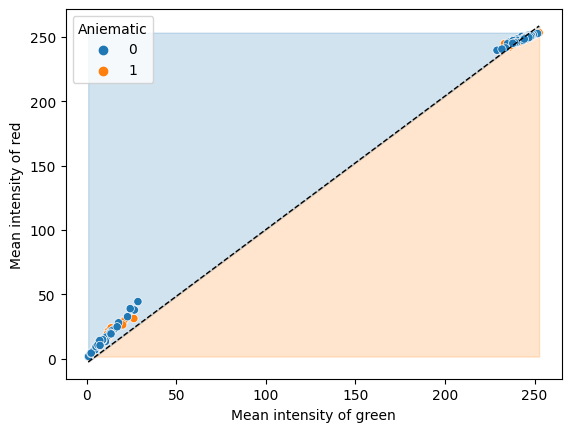

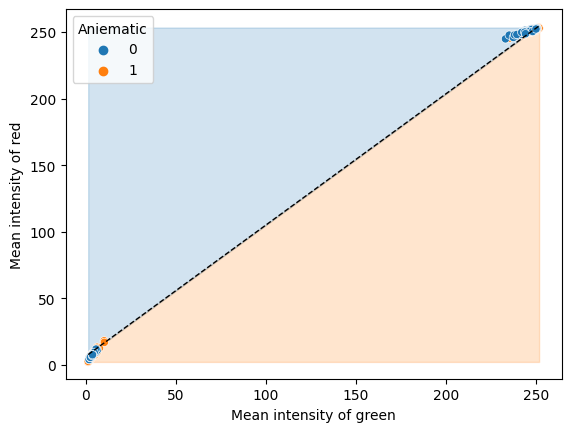

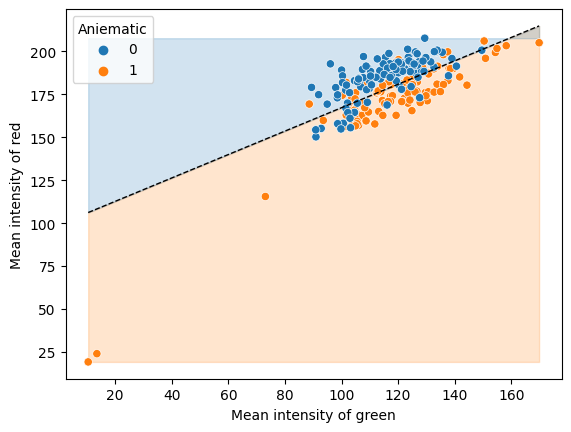

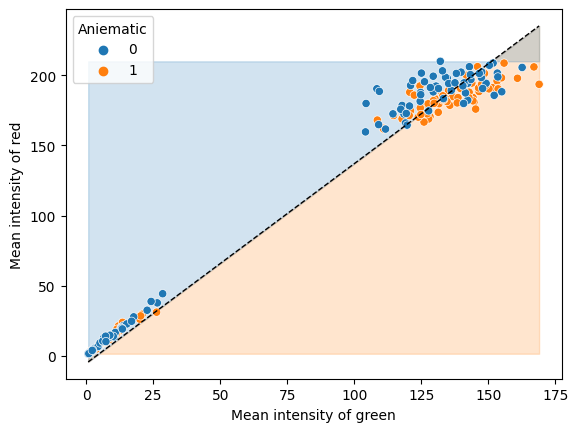

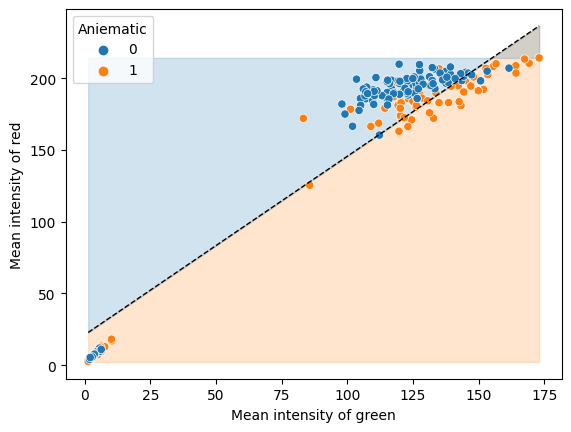

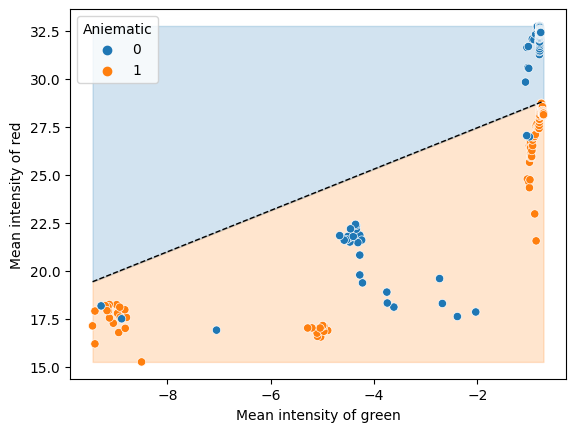

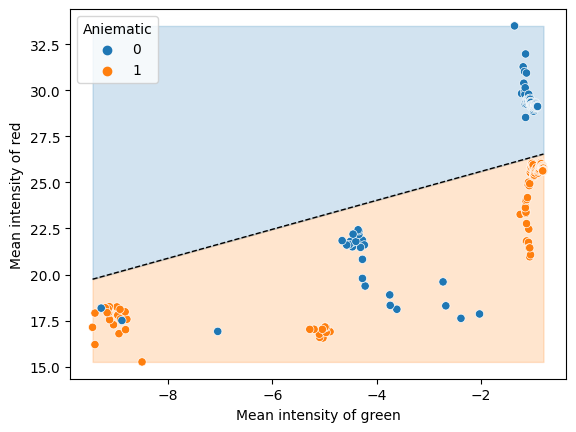

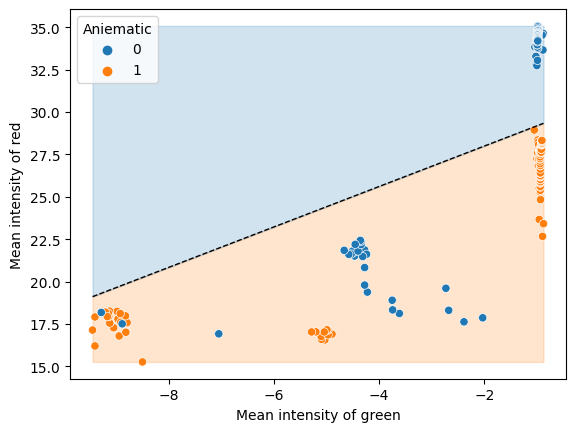

In [ ]:
def plot_log_model_decision_boundary(clf,data):
  b = clf.intercept_[0]
  w1, w2 = clf.coef_.T
  # Calculate the intercept and gradient of the decision boundary.
  c = -b/w2
  m = -w1/w2

  # Plot the data and the classification with the decision boundary.
  xmin = min(data['Mean intensity of green'])
  xmax=max(data['Mean intensity of green'])
  ymin = min(data['Mean intensity of red'])
  ymax=max(data['Mean intensity of red'])
  xd = np.array([xmin, xmax])
  yd = m*xd + c
  plt.plot(xd, yd, 'k', lw=1, ls='--')
  plt.fill_between(xd, yd, ymin, color='tab:orange', alpha=0.2)
  plt.fill_between(xd, yd, ymax, color='tab:blue', alpha=0.2) 
  sns.scatterplot(x='Mean intensity of green', y='Mean intensity of red', data=data,
                hue='Aniematic')
  plt.show()
plot_log_model_decision_boundary(logreg_cielab_fp,data_cielab_fp)
plot_log_model_decision_boundary(logreg_cielab_f,data_cielab_f)
plot_log_model_decision_boundary(logreg_cielab_p,data_cielab_p)

plot_log_model_decision_boundary(logreg_rgb_fp,data_rgb_fp)
plot_log_model_decision_boundary(logreg_rgb_f,data_rgb_f)
plot_log_model_decision_boundary(logreg_rgb_p,data_rgb_p)

plot_log_model_decision_boundary(logreg_rgb_fp_nb,data_rgb_fp_no_background)
plot_log_model_decision_boundary(logreg_rgb_f_nb,data_rgb_f_no_background)
plot_log_model_decision_boundary(logreg_rgb_p_nb,data_rgb_p_no_background)

#plot_log_model_decision_boundary(logreg_cielab_egypt,data_egypt_cielab)


plot_log_model_decision_boundary(logreg_cielab_fp_m,df_cielab_mixed_data_fp)
plot_log_model_decision_boundary(logreg_cielab_f_m,df_cielab_mixed_data_f)
plot_log_model_decision_boundary(logreg_cielab_p_m,df_cielab_mixed_data_p)


In [ ]:

#cross validation
from sklearn.model_selection import cross_val_score
clf = logreg_cielab_fp_m
scores = cross_val_score(clf, x_cielab_mixed_fp, y_cielab_mixed_fp, cv=10)
np.mean(scores)


0.7924501424501426

Hyperparameters of SVM

In [ ]:
param_svm = {'kernel' : ('poly', 'rbf'), 'C':[0.01, 0.1, 0.5, 1, 10]}
svm_model=svm.SVC() 
def svm_hyper_parameters(x_train,y_train):
  svm_gscv = GridSearchCV(svm_model, param_svm)
  svm_gscv.fit(x_train, y_train)
  svm_best_parameters=svm_gscv.best_params_
  C_svm=svm_best_parameters['C']
  kernel_svm=svm_best_parameters['kernel']
  print("C value is : ",C_svm,"kernal is:",kernel_svm)

  return(C_svm,kernel_svm)

C_svm_cielab_fp,kernel_svm_cielab_fp=svm_hyper_parameters(x_train_cielab_fp, y_train_cielab_fp)
C_svm_cielab_f,kernel_svm_cielab_f=svm_hyper_parameters(x_train_cielab_f, y_train_cielab_f)
C_svm_cielab_p,kernel_svm_cielab_p=svm_hyper_parameters(x_train_cielab_p, y_train_cielab_p)

C_svm_rgb_fp,kernel_svm_rgb_fp=svm_hyper_parameters(x_train_rgb_fp, y_train_rgb_fp)
C_svm_rgb_f,kernel_svm_rgb_f=svm_hyper_parameters(x_train_rgb_f, y_train_rgb_f)
C_svm_rgb_p,kernel_svm_rgb_p=svm_hyper_parameters(x_train_rgb_p, y_train_rgb_p)

C_svm_rgb_fp_nb,kernel_svm_rgb_fp_nb=svm_hyper_parameters(x_train_rgb_fp_nb, y_train_rgb_fp_nb)
C_svm_rgb_f_nb,kernel_svm_rgb_f_nb=svm_hyper_parameters(x_train_rgb_f_nb, y_train_rgb_f_nb)
C_svm_rgb_p_nb,kernel_svm_rgb_p_nb=svm_hyper_parameters(x_train_rgb_p_nb, y_train_rgb_p_nb)

C_svm_cielab_fp_m,kernel_svm_cielab_fp_m=svm_hyper_parameters(x_train_cielab_fp_m, y_train_cielab_fp_m)
C_svm_cielab_f_m,kernel_svm_cielab_f_m=svm_hyper_parameters(x_train_cielab_f_m, y_train_cielab_f_m)
C_svm_cielab_p_m,kernel_svm_cielab_p_m=svm_hyper_parameters(x_train_cielab_p_m, y_train_cielab_p_m)

C value is :  0.5 kernal is: rbf
C value is :  0.1 kernal is: poly
C value is :  0.01 kernal is: poly
C value is :  0.1 kernal is: poly
C value is :  10 kernal is: poly
C value is :  0.01 kernal is: poly
C value is :  10 kernal is: rbf
C value is :  10 kernal is: rbf
C value is :  10 kernal is: rbf
C value is :  0.5 kernal is: rbf
C value is :  10 kernal is: poly
C value is :  0.01 kernal is: poly


Training , resting and scoring of SVM

In [ ]:
def svm_training_testing_scoring(c,kernel,x_train,x_test,y_train,y_test):
  svm_clf = svm.SVC(C=  c,kernel= kernel)
  svm_clf.fit(x_train,y_train)
  svm_train=svm_clf.score(x_train,y_train)
  svm_test=svm_clf.score(x_test,y_test)
  print("svm train score is:",svm_train,"svm test is",svm_test)
  return svm_clf


svm_cielab_fp = svm_training_testing_scoring(C_svm_cielab_fp,kernel_svm_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
svm_cielab_f = svm_training_testing_scoring(C_svm_cielab_f,kernel_svm_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
svm_cielab_p = svm_training_testing_scoring(C_svm_cielab_p,kernel_svm_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

svm_rgb_fp = svm_training_testing_scoring(C_svm_rgb_fp, kernel_svm_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
svm_rgb_f = svm_training_testing_scoring(C_svm_rgb_f,kernel_svm_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
svm_rgb_p = svm_training_testing_scoring(C_svm_rgb_p,kernel_svm_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

svm_rgb_fp_nb = svm_training_testing_scoring(C_svm_rgb_fp_nb, kernel_svm_rgb_fp_nb,x_train_rgb_fp_nb,x_test_rgb_fp_nb,y_train_rgb_fp_nb,y_test_rgb_fp_nb)
svm_rgb_f_nb = svm_training_testing_scoring(C_svm_rgb_f_nb,kernel_svm_rgb_f_nb,x_train_rgb_f_nb,x_test_rgb_f_nb,y_train_rgb_f_nb,y_test_rgb_f_nb)
svm_rgb_p_nb = svm_training_testing_scoring(C_svm_rgb_p_nb,kernel_svm_rgb_p_nb,x_train_rgb_p_nb,x_test_rgb_p_nb,y_train_rgb_p_nb,y_test_rgb_p_nb)

svm_cielab_fp_m = svm_training_testing_scoring(C_svm_cielab_fp_m,kernel_svm_cielab_fp_m,x_train_cielab_fp_m,x_test_cielab_fp_m,y_train_cielab_fp_m,y_test_cielab_fp_m)
svm_cielab_f_m = svm_training_testing_scoring(C_svm_cielab_f_m,kernel_svm_cielab_f_m,x_train_cielab_f_m,x_test_cielab_f_m,y_train_cielab_f_m,y_test_cielab_f_m)
svm_cielab_p_m = svm_training_testing_scoring(C_svm_cielab_p_m,kernel_svm_cielab_p_m,x_train_cielab_p_m,x_test_cielab_p_m,y_train_cielab_p_m,y_test_cielab_p_m)

svm train score is: 0.9863945578231292 svm test is 1.0
svm train score is: 1.0 svm test is 1.0
svm train score is: 1.0 svm test is 1.0
svm train score is: 0.8027210884353742 svm test is 0.7619047619047619
svm train score is: 0.5945945945945946 svm test is 0.5625
svm train score is: 0.695364238410596 svm test is 0.5846153846153846
svm train score is: 0.7687074829931972 svm test is 0.746031746031746
svm train score is: 0.668918918918919 svm test is 0.734375
svm train score is: 0.8278145695364238 svm test is 0.7846153846153846
svm train score is: 0.893048128342246 svm test is 0.8888888888888888
svm train score is: 0.9523809523809523 svm test is 0.9506172839506173
svm train score is: 0.8900523560209425 svm test is 0.927710843373494


In [ ]:
from sklearn.model_selection import cross_val_score
clf = svm_cielab_fp_m
svm_scores = cross_val_score(clf, x_cielab_mixed_fp, y_cielab_mixed_fp, cv=10)
np.mean(svm_scores)

0.8887464387464388

Hyperparameters of decision trees

In [ ]:
param_tree={'criterion':('gini', 'entropy'),'max_depth':[2,4,6,8,10,12]}
tree_model=DecisionTreeClassifier() 

def tree_hyper_parameters(x_train,y_train):
  tree_gscv= GridSearchCV(tree_model, param_tree)
  tree_gscv.fit(x_train, y_train)
  tree_best_parameters=tree_gscv.best_params_
  max_depth=tree_best_parameters['max_depth']
  criterion=tree_best_parameters['criterion']
  print("max depth is : ",max_depth,"criterion is:",criterion)

  return(max_depth,criterion)



max_depth_cielab_fp,criterion_cielab_fp=tree_hyper_parameters(x_train_cielab_fp,y_train_cielab_fp)
max_depth_cielab_f,criterion_cielab_f=tree_hyper_parameters(x_train_cielab_f,y_train_cielab_f)
max_depth_cielab_p,criterion_cielab_p=tree_hyper_parameters(x_train_cielab_p,y_train_cielab_p)

max_depth_rgb_fp,criterion_rgb_fp=tree_hyper_parameters(x_train_rgb_fp,y_train_rgb_fp)
max_depth_rgb_f,criterion_rgb_f=tree_hyper_parameters(x_train_rgb_f,y_train_rgb_f)
max_depth_rgb_p,criterion_rgb_p=tree_hyper_parameters(x_train_rgb_p,y_train_rgb_p)

max_depth_rgb_fp_nb,criterion_rgb_fp_nb=tree_hyper_parameters(x_train_rgb_fp_nb,y_train_rgb_fp_nb)
max_depth_rgb_f_nb,criterion_rgb_f_nb=tree_hyper_parameters(x_train_rgb_f_nb,y_train_rgb_f_nb)
max_depth_rgb_p_nb,criterion_rgb_p_nb=tree_hyper_parameters(x_train_rgb_p_nb,y_train_rgb_p_nb)

max_depth_cielab_fp_m,criterion_cielab_fp_m=tree_hyper_parameters(x_train_cielab_fp_m,y_train_cielab_fp_m)
max_depth_cielab_f_m,criterion_cielab_f_m=tree_hyper_parameters(x_train_cielab_f_m,y_train_cielab_f_m)
max_depth_cielab_p_m,criterion_cielab_p_m=tree_hyper_parameters(x_train_cielab_p_m,y_train_cielab_p_m)

max depth is :  4 criterion is: gini
max depth is :  2 criterion is: gini
max depth is :  2 criterion is: gini
max depth is :  4 criterion is: gini
max depth is :  10 criterion is: gini
max depth is :  6 criterion is: entropy
max depth is :  6 criterion is: entropy
max depth is :  10 criterion is: entropy
max depth is :  4 criterion is: gini
max depth is :  4 criterion is: entropy
max depth is :  4 criterion is: gini
max depth is :  4 criterion is: gini


Training,testing and scoring of decision tress

In [ ]:
def tree_training_testing_scoring(criterion,max_depth,x_train,x_test,y_train,y_test):
  clf_tree = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)
  clf_tree.fit(x_train, y_train)
  tree_train=clf_tree.score(x_train, y_train)
  tree_test=clf_tree.score(x_test, y_test)
  print("tree train score is:",tree_train,"tree test is",tree_test)
  return clf_tree


clf_tree_cielab_fp = tree_training_testing_scoring(criterion_cielab_fp,max_depth_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
clf_tree_cielab_f = tree_training_testing_scoring(criterion_cielab_f,max_depth_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
clf_tree_cielab_p = tree_training_testing_scoring(criterion_cielab_p,max_depth_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

clf_tree_rgb_fp = tree_training_testing_scoring(criterion_rgb_fp,max_depth_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
clf_tree_rgb_f = tree_training_testing_scoring(criterion_rgb_f,max_depth_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
clf_tree_rgb_p = tree_training_testing_scoring(criterion_rgb_p,max_depth_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

clf_tree_rgb_fp_nb = tree_training_testing_scoring(criterion_rgb_fp_nb ,max_depth_rgb_fp_nb ,x_train_rgb_fp_nb ,x_test_rgb_fp_nb ,y_train_rgb_fp_nb ,y_test_rgb_fp_nb )
clf_tree_rgb_f_nb  = tree_training_testing_scoring(criterion_rgb_f_nb ,max_depth_rgb_f_nb ,x_train_rgb_f_nb ,x_test_rgb_f_nb ,y_train_rgb_f_nb ,y_test_rgb_f_nb )
clf_tree_rgb_p_nb  = tree_training_testing_scoring(criterion_rgb_p_nb ,max_depth_rgb_p_nb ,x_train_rgb_p_nb ,x_test_rgb_p_nb ,y_train_rgb_p_nb ,y_test_rgb_p_nb )

clf_tree_cielab_fp_m = tree_training_testing_scoring(criterion_cielab_fp_m,max_depth_cielab_fp_m,x_train_cielab_fp_m,x_test_cielab_fp_m,y_train_cielab_fp_m,y_test_cielab_fp_m)
clf_tree_cielab_f_m = tree_training_testing_scoring(criterion_cielab_f_m,max_depth_cielab_f_m,x_train_cielab_f_m,x_test_cielab_f_m,y_train_cielab_f_m,y_test_cielab_f_m)
clf_tree_cielab_p_m = tree_training_testing_scoring(criterion_cielab_p_m,max_depth_cielab_p_m,x_train_cielab_p_m,x_test_cielab_p_m,y_train_cielab_p_m,y_test_cielab_p_m)

tree train score is: 1.0 tree test is 0.9841269841269841
tree train score is: 1.0 tree test is 1.0
tree train score is: 1.0 tree test is 1.0
tree train score is: 0.782312925170068 tree test is 0.6507936507936508
tree train score is: 0.75 tree test is 0.609375
tree train score is: 0.9072847682119205 tree test is 0.6615384615384615
tree train score is: 0.9115646258503401 tree test is 0.7619047619047619
tree train score is: 0.9391891891891891 tree test is 0.640625
tree train score is: 0.8675496688741722 tree test is 0.7384615384615385
tree train score is: 1.0 tree test is 0.9506172839506173
tree train score is: 0.9894179894179894 tree test is 0.9876543209876543
tree train score is: 0.9895287958115183 tree test is 0.9879518072289156


In [ ]:
from sklearn.model_selection import cross_val_score
clf = clf_tree_cielab_fp_m
dt_scores = cross_val_score(clf, x_cielab_mixed_fp, y_cielab_mixed_fp, cv=10)
np.mean(dt_scores)

0.9128205128205128

Training ,testing and scoring of naive bayes

In [ ]:
def nb_training_testing_scoring(x_train,x_test,y_train,y_test):
  gauss_model= GaussianNB()
  gauss_model.fit(x_train, y_train)
  nb_train=gauss_model.score(x_train, y_train)
  nb_test=gauss_model.score(x_test, y_test)
  print("nb train score is:",nb_train,"nb test is",nb_test)
  return gauss_model
gauss_model_cielab_fp=nb_training_testing_scoring(x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
gauss_model_cielab_f = nb_training_testing_scoring(x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
gauss_model_cielab_p = nb_training_testing_scoring(x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

gauss_model_rgb_fp = nb_training_testing_scoring(x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
gauss_model_rgb_f = nb_training_testing_scoring(x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
gauss_model_rgb_p = nb_training_testing_scoring(x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

gauss_model_rgb_fp_nb = nb_training_testing_scoring(x_train_rgb_fp_nb,x_test_rgb_fp_nb,y_train_rgb_fp_nb,y_test_rgb_fp_nb)
gauss_model_rgb_f_nb = nb_training_testing_scoring(x_train_rgb_f_nb,x_test_rgb_f_nb,y_train_rgb_f_nb,y_test_rgb_f_nb)
gauss_model_rgb_p_nb = nb_training_testing_scoring(x_train_rgb_p_nb,x_test_rgb_p_nb,y_train_rgb_p_nb,y_test_rgb_p_nb)

gauss_model_cielab_fp_m=nb_training_testing_scoring(x_train_cielab_fp_m,x_test_cielab_fp_m,y_train_cielab_fp_m,y_test_cielab_fp_m)
gauss_model_cielab_f_m = nb_training_testing_scoring(x_train_cielab_f_m,x_test_cielab_f_m,y_train_cielab_f_m,y_test_cielab_f_m)
gauss_model_cielab_p_m = nb_training_testing_scoring(x_train_cielab_p_m,x_test_cielab_p_m,y_train_cielab_p_m,y_test_cielab_p_m)

nb train score is: 0.9727891156462585 nb test is 0.9841269841269841
nb train score is: 1.0 nb test is 1.0
nb train score is: 1.0 nb test is 1.0
nb train score is: 0.5238095238095238 nb test is 0.5238095238095238
nb train score is: 0.5608108108108109 nb test is 0.59375
nb train score is: 0.695364238410596 nb test is 0.5846153846153846
nb train score is: 0.6190476190476191 nb test is 0.6031746031746031
nb train score is: 0.5405405405405406 nb test is 0.640625
nb train score is: 0.695364238410596 nb test is 0.5846153846153846
nb train score is: 0.5508021390374331 nb test is 0.5802469135802469
nb train score is: 0.5502645502645502 nb test is 0.6172839506172839
nb train score is: 0.6178010471204188 nb test is 0.6506024096385542


Hyperparameters of knn

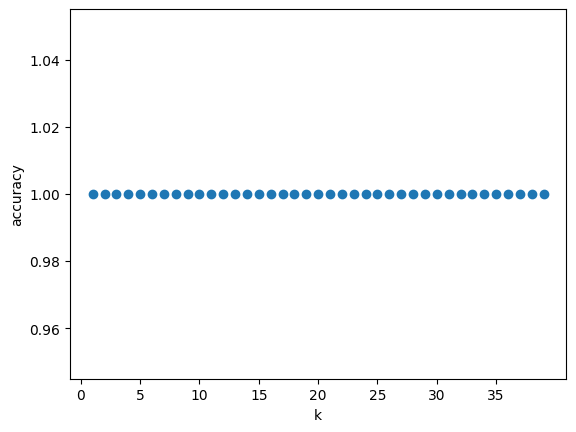

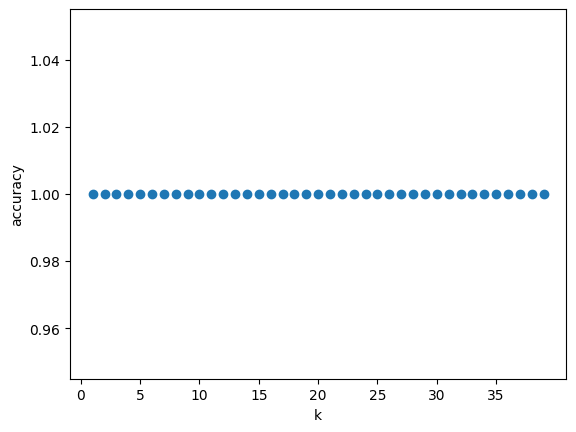

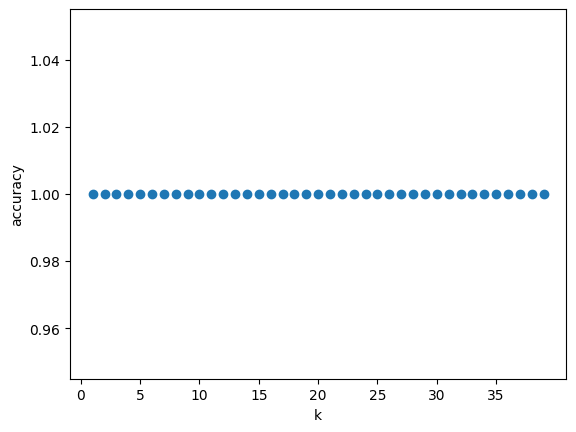

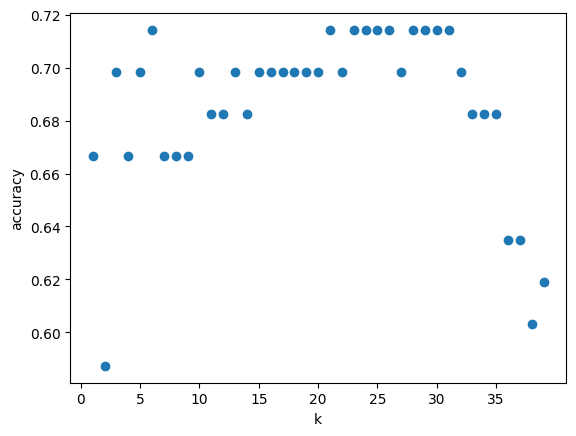

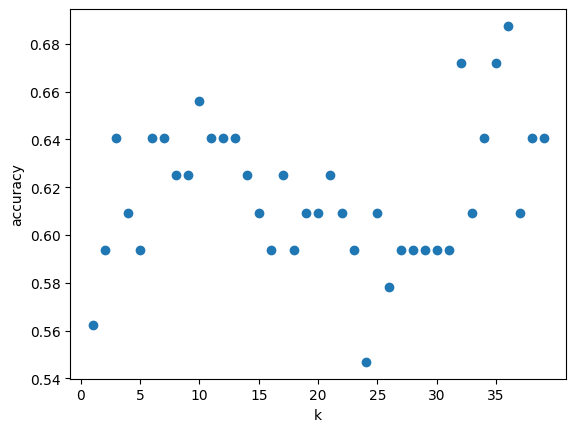

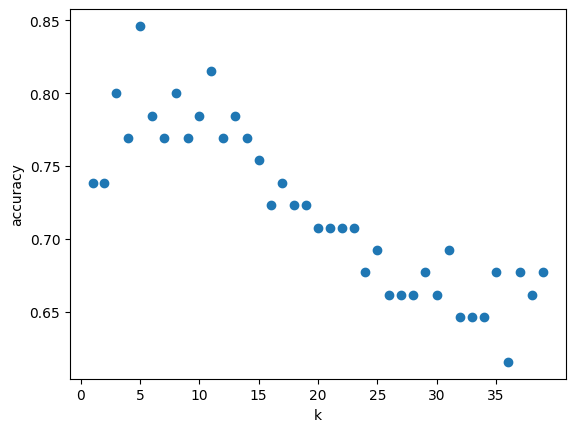

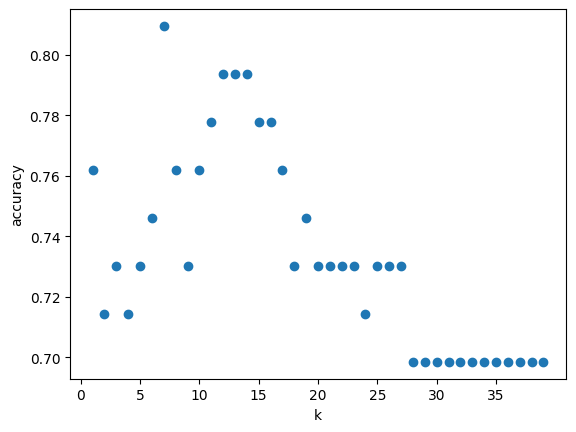

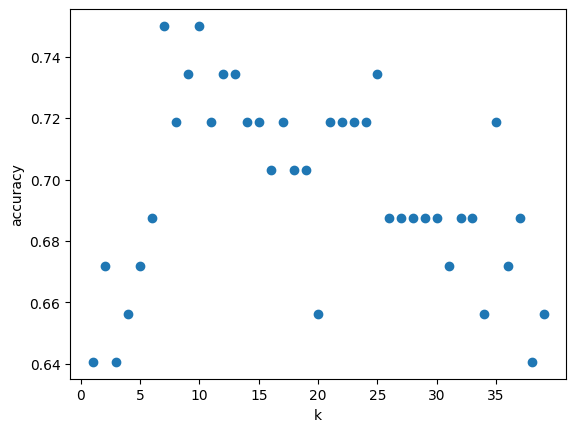

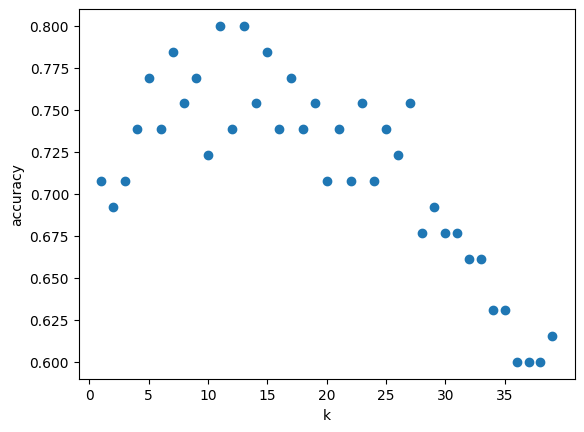

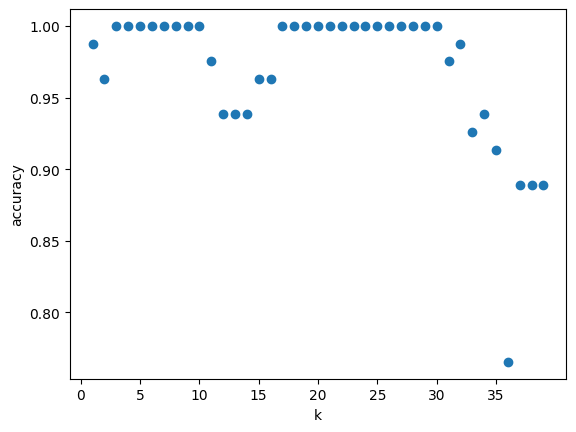

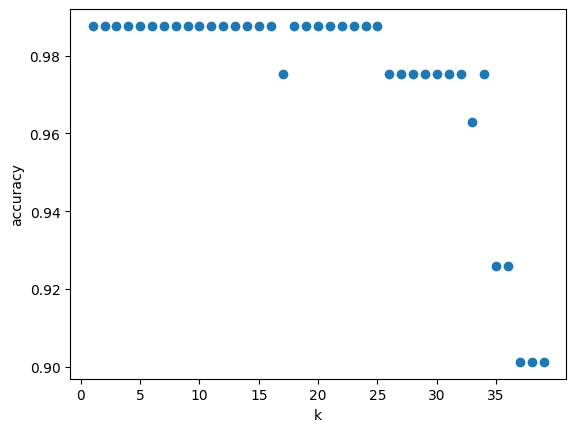

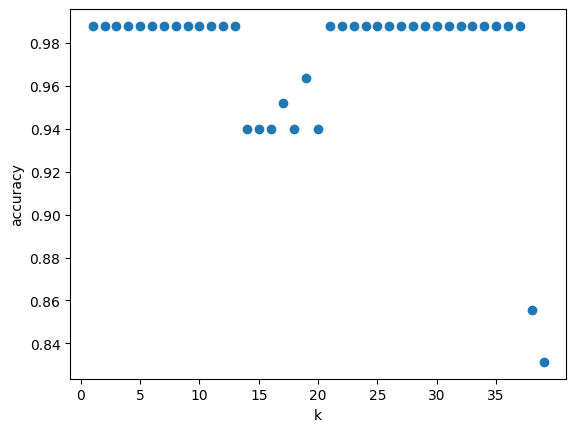

In [ ]:
#Visualization
#to choose best k for knn
import matplotlib.pyplot as plt
%matplotlib inline
def visualization_for_kmeans(x_train,x_test,y_train,y_test):
  k_range = range(1,40)
  scores = []

  for k in k_range:
      knn = KNeighborsClassifier(n_neighbors = k)
      knn.fit(x_train, y_train)
      scores.append(knn.score(x_test, y_test))
  max_score=max(scores)
  k_number=scores.index(max_score)+1

  plt.figure()
  plt.xlabel('k')
  plt.ylabel('accuracy')
  plt.scatter(k_range, scores)
  plt.xticks([0,5,10,15,20,25,30,35]);
  return k_number

k_number_cielab_fp=visualization_for_kmeans(x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
k_number_cielab_f=visualization_for_kmeans(x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
k_number_cielab_p=visualization_for_kmeans(x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

k_number_rgb_fp=visualization_for_kmeans(x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
k_number_rgb_f=visualization_for_kmeans(x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
k_number_rgb_p=visualization_for_kmeans(x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

k_number_rgb_fp_nb=visualization_for_kmeans(x_train_rgb_fp_nb,x_test_rgb_fp_nb,y_train_rgb_fp_nb,y_test_rgb_fp_nb)
k_number_rgb_f_nb=visualization_for_kmeans(x_train_rgb_f_nb,x_test_rgb_f_nb,y_train_rgb_f_nb,y_test_rgb_f_nb)
k_number_rgb_p_nb=visualization_for_kmeans(x_train_rgb_p_nb,x_test_rgb_p_nb,y_train_rgb_p_nb,y_test_rgb_p_nb)

k_number_cielab_fp_m=visualization_for_kmeans(x_train_cielab_fp_m,x_test_cielab_fp_m,y_train_cielab_fp_m,y_test_cielab_fp_m)
k_number_cielab_f_m=visualization_for_kmeans(x_train_cielab_f_m,x_test_cielab_f_m,y_train_cielab_f_m,y_test_cielab_f_m)
k_number_cielab_p_m=visualization_for_kmeans(x_train_cielab_p_m,x_test_cielab_p_m,y_train_cielab_p_m,y_test_cielab_p_m)

Training,testing and scoring of knn

In [ ]:
def knn_model_training_testing_scoring(k_number,x_train,x_test,y_train,y_test):
  knn = KNeighborsClassifier(n_neighbors=k_number)
  #training
  knn.fit(x_train, y_train)
  #scores
  #training
  knn_train=knn.score(x_train, y_train)
  #testing
  knn_test=knn.score(x_test, y_test)
  print("knn train score is:",knn_train,"knn test score is",knn_test)
  return knn

knn_model_cielab_fp=knn_model_training_testing_scoring(k_number_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
knn_model_cielab_f=knn_model_training_testing_scoring(k_number_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
knn_model_cielab_p=knn_model_training_testing_scoring(k_number_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

knn_model_rgb_fp=knn_model_training_testing_scoring(k_number_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
knn_model_rgb_f=knn_model_training_testing_scoring(k_number_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
knn_model_rgb_p=knn_model_training_testing_scoring(k_number_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

knn_model_rgb_fp_nb=knn_model_training_testing_scoring(k_number_rgb_fp_nb,x_train_rgb_fp_nb,x_test_rgb_fp_nb,y_train_rgb_fp_nb,y_test_rgb_fp_nb)
knn_model_rgb_f_nb=knn_model_training_testing_scoring(k_number_rgb_f_nb,x_train_rgb_f_nb,x_test_rgb_f_nb,y_train_rgb_f_nb,y_test_rgb_f_nb)
knn_model_rgb_p_nb=knn_model_training_testing_scoring(k_number_rgb_p_nb,x_train_rgb_p_nb,x_test_rgb_p_nb,y_train_rgb_p_nb,y_test_rgb_p_nb)

knn_model_cielab_fp_m=knn_model_training_testing_scoring(k_number_cielab_fp_m,x_train_cielab_fp_m,x_test_cielab_fp_m,y_train_cielab_fp_m,y_test_cielab_fp_m)
knn_model_cielab_f_m=knn_model_training_testing_scoring(k_number_cielab_f_m,x_train_cielab_f_m,x_test_cielab_f_m,y_train_cielab_f_m,y_test_cielab_f_m)
knn_model_cielab_p_m=knn_model_training_testing_scoring(k_number_cielab_p_m,x_train_cielab_p_m,x_test_cielab_p_m,y_train_cielab_p_m,y_test_cielab_p_m)

knn train score is: 1.0 knn test score is 1.0
knn train score is: 1.0 knn test score is 1.0
knn train score is: 1.0 knn test score is 1.0
knn train score is: 0.7891156462585034 knn test score is 0.7142857142857143
knn train score is: 0.6148648648648649 knn test score is 0.6875
knn train score is: 0.8278145695364238 knn test score is 0.8461538461538461
knn train score is: 0.782312925170068 knn test score is 0.8095238095238095
knn train score is: 0.722972972972973 knn test score is 0.75
knn train score is: 0.8344370860927153 knn test score is 0.8
knn train score is: 0.9786096256684492 knn test score is 1.0
knn train score is: 1.0 knn test score is 0.9876543209876543
knn train score is: 1.0 knn test score is 0.9879518072289156


In [ ]:
from keras.saving.legacy.model_config import model_from_config
from sklearn.model_selection import cross_val_score
def avg_cross_vaild_score(models_list,x,y,cv):
  avg_score_list=[]
  for model in models_list:
    clf=model
    score=cross_val_score(clf, x, y, cv=cv)
    avg_score_list.append(np.mean(score))
  return(avg_score_list)
knn_models_list=[knn_model_cielab_fp_m,knn_model_cielab_f_m,knn_model_cielab_p_m]   

print(avg_cross_vaild_score(knn_models_list,x_cielab_mixed_p,y_cielab_mixed_p,10))

[0.9259259259259259, 0.9185185185185185, 0.9185185185185185]


Model scores

In [ ]:
models_cielab_fp = []
models_cielab_fp.append(('Cielab fp Logistic Regression:',logreg_cielab_fp))
models_cielab_fp.append(('Cielab fp SVM                :', svm_cielab_fp))
models_cielab_fp.append(('Cielab fp Decision Tree      :', clf_tree_cielab_fp))
models_cielab_fp.append(('Cielab fp Naive Bayes        :',gauss_model_cielab_fp))
models_cielab_fp.append(('Cielab fp KNN                :', knn_model_cielab_fp))

models_cielab_f = []
models_cielab_f.append(('Cielab f Logistic Regression:',logreg_cielab_f))
models_cielab_f.append(('Cielab f SVM                :', svm_cielab_f))
models_cielab_f.append(('Cielab f Decision Tree      :', clf_tree_cielab_f))
models_cielab_f.append(('Cielab f Naive Bayes        :',gauss_model_cielab_f))
models_cielab_f.append(('Cielab f KNN                :', knn_model_cielab_f))

models_cielab_p = []
models_cielab_p.append(('Cielab p Logistic Regression:',logreg_cielab_p))
models_cielab_p.append(('Cielab p SVM                :', svm_cielab_p))
models_cielab_p.append(('Cielab p Decision Tree      :', clf_tree_cielab_p))
models_cielab_p.append(('Cielab p Naive Bayes        :',gauss_model_cielab_p))
models_cielab_p.append(('Cielab p KNN                :', knn_model_cielab_p))

models_rgb_fp = []
models_rgb_fp.append(('rgb fp Logistic Regression:',logreg_rgb_fp))
models_rgb_fp.append(('rgb fp SVM                :', svm_rgb_fp))
models_rgb_fp.append(('rgb fp Decision Tree      :', clf_tree_rgb_fp))
models_rgb_fp.append(('rgb fp Naive Bayes        :',gauss_model_rgb_fp))
models_rgb_fp.append(('rgb fp KNN                :', knn_model_rgb_fp))

models_rgb_f = []
models_rgb_f.append(('rgb f Logistic Regression:',logreg_rgb_f))
models_rgb_f.append(('rgb f SVM                :', svm_rgb_f))
models_rgb_f.append(('rgb f Decision Tree      :', clf_tree_rgb_f))
models_rgb_f.append(('rgb f Naive Bayes        :',gauss_model_rgb_f))
models_rgb_f.append(('rgb f KNN                :', knn_model_rgb_f))

models_rgb_p = []
models_rgb_p.append(('rgb p Logistic Regression:',logreg_rgb_p))
models_rgb_p.append(('rgb p SVM                :', svm_rgb_p))
models_rgb_p.append(('rgb p Decision Tree      :', clf_tree_rgb_p))
models_rgb_p.append(('rgb p Naive Bayes        :',gauss_model_rgb_p))
models_rgb_p.append(('rgb p KNN                :', knn_model_rgb_p))

models_rgb_fp_nb = []
models_rgb_fp_nb.append(('rgb fp nb Logistic Regression:',logreg_rgb_fp_nb))
models_rgb_fp_nb.append(('rgb fp  nb SVM                :', svm_rgb_fp_nb))
models_rgb_fp_nb.append(('rgb fp nb Decision Tree      :', clf_tree_rgb_fp_nb))
models_rgb_fp_nb.append(('rgb fp nb Naive Bayes        :',gauss_model_rgb_fp_nb))
models_rgb_fp_nb.append(('rgb fp nb KNN                :', knn_model_rgb_fp_nb))

models_rgb_f_nb = []
models_rgb_f_nb.append(('rgb f nb Logistic Regression:',logreg_rgb_f_nb))
models_rgb_f_nb.append(('rgb f nb SVM                :', svm_rgb_f_nb))
models_rgb_f_nb.append(('rgb f nb Decision Tree      :', clf_tree_rgb_f_nb))
models_rgb_f_nb.append(('rgb f nb Naive Bayes        :',gauss_model_rgb_f_nb))
models_rgb_f_nb.append(('rgb f nb KNN                :', knn_model_rgb_f))

models_rgb_p_nb = []
models_rgb_p_nb.append(('rgb p nb Logistic Regression:',logreg_rgb_p_nb))
models_rgb_p_nb.append(('rgb p nb SVM                :', svm_rgb_p_nb))
models_rgb_p_nb.append(('rgb p nb Decision Tree      :', clf_tree_rgb_p_nb))
models_rgb_p_nb.append(('rgb p nb Naive Bayes        :',gauss_model_rgb_p_nb))
models_rgb_p_nb.append(('rgb p nb KNN                :', knn_model_rgb_p_nb))

models_cielab_fp_m = []
models_cielab_fp_m.append(('Cielab fp Logistic Regression:',logreg_cielab_fp_m))
models_cielab_fp_m.append(('Cielab fp SVM                :', svm_cielab_fp_m))
models_cielab_fp_m.append(('Cielab fp Decision Tree      :', clf_tree_cielab_fp_m))
models_cielab_fp_m.append(('Cielab fp Naive Bayes        :',gauss_model_cielab_fp_m))
models_cielab_fp_m.append(('Cielab fp KNN                :', knn_model_cielab_fp_m))

models_cielab_f_m = []
models_cielab_f_m.append(('Cielab f Logistic Regression:',logreg_cielab_f_m))
models_cielab_f_m.append(('Cielab f SVM                :', svm_cielab_f_m))
models_cielab_f_m.append(('Cielab f Decision Tree      :', clf_tree_cielab_f_m))
models_cielab_f_m.append(('Cielab f Naive Bayes        :',gauss_model_cielab_f_m))
models_cielab_f_m.append(('Cielab f KNN                :', knn_model_cielab_f_m))

models_cielab_p_m = []
models_cielab_p_m.append(('Cielab p Logistic Regression:',logreg_cielab_p_m))
models_cielab_p_m.append(('Cielab p SVM                :', svm_cielab_p_m))
models_cielab_p_m.append(('Cielab p Decision Tree      :', clf_tree_cielab_p_m))
models_cielab_p_m.append(('Cielab p Naive Bayes        :',gauss_model_cielab_p_m))
models_cielab_p_m.append(('Cielab p KNN                :', knn_model_cielab_p_m))
def print_model_metrics(model_list,x_train,x_test,y_train,y_test):
  for name, model in model_list:
      model.fit(x_train, y_train)
      pred = model.predict(x_test).astype(int)
      print(name,accuracy_score(y_test, pred))
      print('Precision: %.3f' % precision_score(y_test, pred))
      print('Recall: %.3f' % recall_score(y_test, pred))   	
      print('F1 Score: %.3f' % f1_score(y_test, pred))
      print(confusion_matrix(y_test, pred))
      print("____________________________________________________________________")
print_model_metrics(models_cielab_fp,x_train_cielab_fp,x_test_cielab_fp,y_train_cielab_fp,y_test_cielab_fp)
print_model_metrics(models_cielab_f,x_train_cielab_f,x_test_cielab_f,y_train_cielab_f,y_test_cielab_f)
print_model_metrics(models_cielab_p,x_train_cielab_p,x_test_cielab_p,y_train_cielab_p,y_test_cielab_p)

print_model_metrics(models_rgb_fp,x_train_rgb_fp,x_test_rgb_fp,y_train_rgb_fp,y_test_rgb_fp)
print_model_metrics(models_rgb_f,x_train_rgb_f,x_test_rgb_f,y_train_rgb_f,y_test_rgb_f)
print_model_metrics(models_rgb_p,x_train_rgb_p,x_test_rgb_p,y_train_rgb_p,y_test_rgb_p)

print_model_metrics(models_rgb_fp_nb,x_train_rgb_fp_nb,x_test_rgb_fp_nb,y_train_rgb_fp_nb,y_test_rgb_fp_nb)
print_model_metrics(models_rgb_f_nb,x_train_rgb_f_nb,x_test_rgb_f_nb,y_train_rgb_f_nb,y_test_rgb_f_nb)
print_model_metrics(models_rgb_p_nb,x_train_rgb_p_nb,x_test_rgb_p_nb,y_train_rgb_p_nb,y_test_rgb_p_nb)

print_model_metrics(models_cielab_fp_m,x_train_cielab_fp_m,x_test_cielab_fp_m,y_train_cielab_fp_m,y_test_cielab_fp_m)
print_model_metrics(models_cielab_f_m,x_train_cielab_f_m,x_test_cielab_f_m,y_train_cielab_f_m,y_test_cielab_f_m)
print_model_metrics(models_cielab_p_m,x_train_cielab_p_m,x_test_cielab_p_m,y_train_cielab_p_m,y_test_cielab_p_m)

Cielab fp Logistic Regression: 1.0
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
[[34  0]
 [ 0 29]]
____________________________________________________________________
Cielab fp SVM                : 1.0
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
[[34  0]
 [ 0 29]]
____________________________________________________________________
Cielab fp Decision Tree      : 0.9841269841269841
Precision: 1.000
Recall: 0.966
F1 Score: 0.982
[[34  0]
 [ 1 28]]
____________________________________________________________________
Cielab fp Naive Bayes        : 0.9841269841269841
Precision: 0.967
Recall: 1.000
F1 Score: 0.983
[[33  1]
 [ 0 29]]
____________________________________________________________________
Cielab fp KNN                : 1.0
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
[[34  0]
 [ 0 29]]
____________________________________________________________________
Cielab f Logistic Regression: 1.0
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
[[33  0]
 [ 0 31]]
____________________

In [ ]:
x_rgb_egypt=egypt_dataframe_cielab[features]
y_rgb_egypt=egypt_dataframe_cielab["Aniematic"]
#y_rgb_egypt=egypt_dataframe_cielab.values.ravel()
print(y_rgb_egypt.shape)
print(x_rgb_egypt.shape)

(58,)
(58, 2)


In [ ]:
egy_score=logreg_cielab_fp.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=logreg_cielab_f.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=logreg_cielab_p.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)

0.46551724137931033
0.5344827586206896
0.5344827586206896


In [ ]:
egy_score=svm_cielab_fp.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=svm_cielab_f.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=svm_cielab_p.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)

0.5344827586206896
0.5344827586206896
0.5344827586206896


In [ ]:
egy_score=gauss_model_cielab_fp.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=gauss_model_cielab_f.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=gauss_model_cielab_p.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)

0.5344827586206896
0.5344827586206896
0.5344827586206896


In [ ]:
egy_score=knn_model_cielab_fp.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=knn_model_cielab_f.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=knn_model_cielab_p.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)

0.5344827586206896
0.5344827586206896
0.5344827586206896


In [ ]:
egy_score=clf_tree_cielab_fp.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=clf_tree_cielab_f.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)
egy_score=clf_tree_cielab_p.score(x_rgb_egypt, y_rgb_egypt)
print(egy_score)

0.46551724137931033
0.5344827586206896
0.5344827586206896


Workflow pipeline 

1)getting image

2)preporcessing:

2.1)removing white background

2.2)converting pixels to cielab

3)feature estraction

4)prediciton

In [ ]:
def Remove_background(pixel):
  white=255
  black=0
  white_counter=0
  black_counter=0
  is_background=False
  for i in range(0,3):
    if(pixel[i]==white):
      white_counter=white_counter+1
    if(pixel[i]==black):
      black_counter=black_counter+1
  if(white_counter==3 or black_counter==3):
    is_background=True
  return(is_background)
#to reach cielab you must go from rgb to xyz
#these conversions are from a website
def convert_from_rgb_to_xyz(pixel):
  var_R = ( pixel[0] / 255 )
  var_G = ( pixel[1] / 255 )
  var_B = ( pixel[2] / 255 )

  if ( var_R > 0.04045 ):
    var_R = ( ( var_R + 0.055 ) / 1.055 ) ** 2.4
  else:
    var_R = var_R / 12.92
  if ( var_G > 0.04045 ):
    var_G = ( ( var_G + 0.055 ) / 1.055 ) ** 2.4
  else:
    var_G = var_G / 12.92
  if ( var_B > 0.04045 ):
    var_B = ( ( var_B + 0.055 ) / 1.055 )** 2.4
  else:
    var_B = var_B / 12.92

  var_R = var_R * 100
  var_G = var_G * 100
  var_B = var_B * 100

  X = var_R * 0.4124 + var_G * 0.3576 + var_B * 0.1805
  Y = var_R * 0.2126 + var_G * 0.7152 + var_B * 0.0722
  Z = var_R * 0.0193 + var_G * 0.1192 + var_B * 0.9505
  return [X,Y,Z]

def convert_from_xyz_to_lab(xyz_pixel):
  #these constants are from skimage documentation 
  X=95.047
  Y=100.000
  Z=108.883
  var_X = xyz_pixel[0] / X
  var_Y = xyz_pixel[1] / Y
  var_Z = xyz_pixel[2] / Z

  if ( var_X > 0.008856 ):
     var_X = var_X** ( 1/3 )
  else:
     var_X = ( 7.787 * var_X ) + ( 16 / 116 )
  if ( var_Y > 0.008856 ):
     var_Y = var_Y ** ( 1/3 )
  else:
     var_Y = ( 7.787 * var_Y ) + ( 16 / 116 )
  if ( var_Z > 0.008856 ):
     var_Z = var_Z ** ( 1/3 )
  else :
     var_Z = ( 7.787 * var_Z ) + ( 16 / 116 )

  l = ( 116 * var_Y ) - 16
  a = 500 * ( var_X - var_Y )
  b = 200 * ( var_Y - var_Z )
  return l,a,b
#function takes image path and return features i.e mean intensity red & green
def image_preprocessing_and_feature_extrction(folder_path_of_image):
  list_of_red_components=[]
  list_of_green_components=[]
  #read image
  image = io.imread(folder_path_of_image)
  image_height=image.shape[0]
  image_width=image.shape[1]
  list_of_new_image_pixels=[]
  #choose non white pixels in the image
  for h in range(0,image_height):
    for w in range(0,image_width):
      if(Remove_background(image[h][w])==False):
        list_of_new_image_pixels.append(image[h][w])

  list_of_a_values=[]
  #convert pixel list from rgb to cielab
  #convertion is done pixel by pixel
  for i in range (0,len(list_of_new_image_pixels)):
    converted_to_xyz_pixel=convert_from_rgb_to_xyz(list_of_new_image_pixels[i])
    l,a,b=convert_from_xyz_to_lab(converted_to_xyz_pixel)
    list_of_a_values.append(a)
  #caluclate red and green components for a list 
  for i in range (0,len(list_of_a_values)):
      if(list_of_a_values[i]>0):
        list_of_red_components.append(list_of_a_values[i])
      elif(list_of_a_values[i]<0):
        list_of_green_components.append(list_of_a_values[i])
  mean_green=np.mean(list_of_green_components)
  mean_red=np.mean(list_of_red_components)
  

  

  return mean_green,mean_red
def feature_extraction_rgb(image):
  
  b,g,r = cv2.split(image)

  mean_green=np.mean(g)
  mean_red=np.mean(r)
  

  return mean_green,mean_red

In [ ]:
#mean_g,mean_r=image_preprocessing_and_feature_extrction("/content/anemia.jpg")
#print(mean_g)
#print(mean_r)
#logreg_cielab_p.predict([[mean_g,mean_r]])
ImageFile.LOAD_TRUNCATED_IMAGES = True
image = io.imread("/content/drive/MyDrive/Datasets/Aniemia/Original Dataset/dataset anemia/India/10/20200203_091841_forniceal_palpebral.png")
img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
im_bw = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]
#im_bw = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(im_bw)

In [ ]:
mg=-1
mr=32
logreg_cielab_p.predict([[mg,mr]])


Saving model

In [ ]:
import pickle
filename = 'finalized_knn_rgb_p.sav'
pickle.dump(knn_model_rgb_p, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#send a (1,2)size array to teh below function in the place of x test
# ie.e an array contianing mr,mg
#result = loaded_model.predict(X_test)

Converting model to neural network with preprocessing layers to convert to tf lite


Adjusting functions for neural network formation

In [ ]:
def image_preprocessing_and_feature_extrction_neural_network(image):#image must be rgb
  list_of_red_components=[]
  list_of_green_components=[]

  image_height=image.shape[0]
  image_width=image.shape[1]
  list_of_new_image_pixels=[]
  #choose non white pixels in the image
  for h in range(0,image_height):
    for w in range(0,image_width):
      if(Remove_background(image[h][w])==False):
        list_of_new_image_pixels.append(image[h][w])
  list_of_a_values=[]
  #convert pixel list from rgb to cielab
  #convertion is done pixel by pixel
  for i in range (0,len(list_of_new_image_pixels)):
        converted_to_xyz_pixel=convert_from_rgb_to_xyz(list_of_new_image_pixels[i])
        l,a,b=convert_from_xyz_to_lab(converted_to_xyz_pixel)
        list_of_a_values.append(a)
  #caluclate red and green components for a list 
  for i in range (0,len(list_of_a_values)):
      if(list_of_a_values[i]>0):
        list_of_red_components.append(list_of_a_values[i])
      elif(list_of_a_values[i]<0):
        list_of_green_components.append(list_of_a_values[i])
  mean_green=np.mean(list_of_green_components)
  mean_red=np.mean(list_of_red_components)
  

  

  return mean_green,mean_red

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Datasets/Aniemia/Dataset for dataframe/dataset anemia - Copy/Palpebral Dataset/Aniematic/001_palpebral.jpg")
image.shape
def removing_background_flexiable(image):
  ## (1) Convert to gray, and threshold
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

  ## (2) Morph-op to remove noise
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

  ## (3) Find the max-area contour
  cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
  cnt = sorted(cnts, key=cv2.contourArea)[-1]

  ## (4) Crop and save it
  x,y,w,h = cv2.boundingRect(cnt)
  dst = image[y:y+h, x:x+w]

  dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
  return dst
image.shape


In [ ]:
import tensorflow as tf




#tf.keras.layers.Resizing(height,width)


# fit the sklearn model on the data
#model.add(Lambda(antirectifier))

# create a TF model with the same architecture
tf_model = tf.keras.models.Sequential()
tf_model.add(tf.keras.Input(shape=(3984, 2988, 3)))
#tf_model.add(tf.keras.layers.Lambda(Remove_background))
tf_model.add(tf.keras.layers.Lambda(image_preprocessing_and_feature_extrction_neural_network))
tf_model.add(tf.keras.layers.Dense(1))

# assign the parameters from sklearn to the TF model
tf_model.layers[0].weights[0].assign(logreg_cielab_p.coef_.transpose())
tf_model.layers[0].bias.assign(logreg_cielab_p.intercept_)

# verify the models do the same prediction
assert np.all((tf_model(x_cielab_p) > 0)[:, 0].numpy() == logreg_cielab_p.predict(x_cielab_p))